In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- SessionID 대신 UserID: 명확한 1회 세션의 SessionID를 포함하지 않음
- Rating정보 포함
- Time항목에 UTC Time 포함

# Step1. Data PreProcessing
- 항목별 기본 분석, session length, session time, cleaning등의 작업 진행

## Basic Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [5]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [6]:
rating_distribution = data['Rating'].value_counts(normalize=True)
rating_distribution

4    0.348898
3    0.261142
5    0.226263
2    0.107535
1    0.056162
Name: Rating, dtype: float64

In [7]:
print(f"\n고유한 사용자 수: {data['UserId'].nunique()}")
print(f"고유한 아이템 수: {data['ItemId'].nunique()}")


고유한 사용자 수: 6040
고유한 아이템 수: 3706


In [8]:
# 타임스탬프를 실제 날짜로 변환
data['Time'] = pd.to_datetime(data['Time'], unit='s')

## Session Length Analysis

In [9]:
# 각 UserId에 대한 세션 길이 계산
session_length = data.groupby('UserId').size()

In [10]:
# 각 UserId에 대한 세션 길이 계산
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

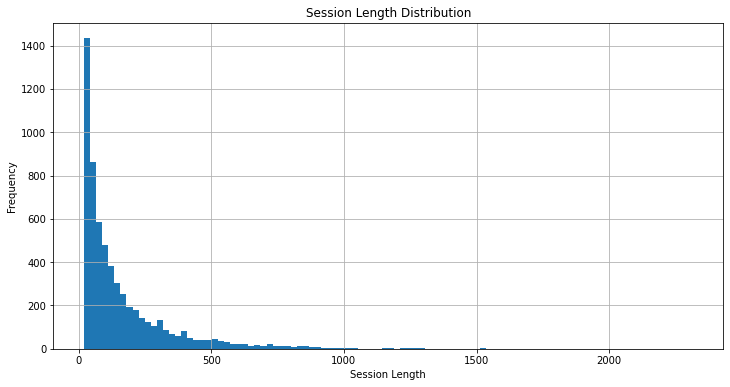

In [11]:
plt.figure(figsize=(12, 6))
session_length.hist(bins=100)
plt.title('Session Length Distribution')
plt.xlabel('Session Length')
plt.ylabel('Frequency')
plt.show()

## Session Time Analysis

In [12]:
# 각 세션의 시작 시간과 종료 시간 계산
session_start_time = data.groupby('UserId')['Time'].min()
session_end_time = data.groupby('UserId')['Time'].max()

In [13]:
# 세션 지속 시간 초 단위 계산
session_duration = (session_end_time - session_start_time).dt.total_seconds()

In [14]:
session_duration.describe()

count    6.040000e+03
mean     8.207777e+06
std      1.917298e+07
min      1.060000e+02
25%      1.207500e+03
50%      4.068500e+03
75%      2.021375e+06
max      8.924779e+07
Name: Time, dtype: float64

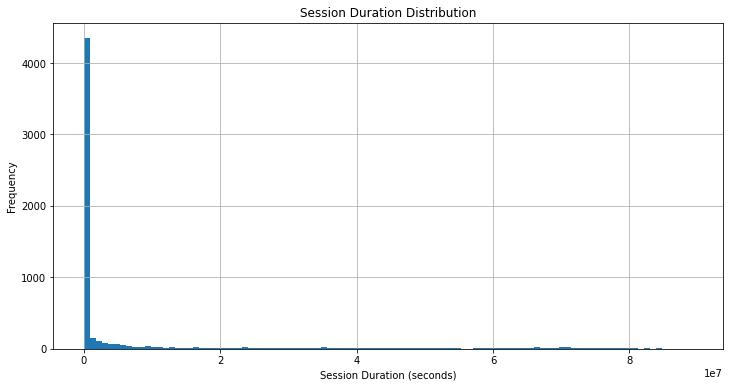

In [15]:
plt.figure(figsize=(12, 6))
session_duration.hist(bins=100)
plt.title('Session Duration Distribution')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

## Data Cleansing

In [16]:
# Rating이 낮은 데이터 제거
data = data[data['Rating'] >= 3]

In [17]:
# 세션 길이가 2 이하인 세션 제거
session_length = data.groupby('UserId').size()
data = data[data['UserId'].isin(session_length[session_length > 2].index)]

In [18]:
# 데이터셋 분할
split_1 = int(len(data) * 0.8)
split_2 = int(len(data) * 0.9)

tr = data[:split_1]
val = data[split_1:split_2]
test = data[split_2:]

In [19]:
# id2idx 매핑 생성
id2idx = {item_id: index for index, item_id in enumerate(tr['ItemId'].unique())}

# 인덱싱 함수 정의
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # 없는 아이템은 -1로 처리
    df = df[df['item_idx'] != -1]  # 없는 아이템 제거
    return df

# 데이터 인덱싱 적용
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [20]:
# 최대값 확인
print(f"Train dataset max ItemId: {tr['item_idx'].max()}")
print(f"Validation dataset max ItemId: {val['item_idx'].max()}")
print(f"Test dataset max ItemId: {test['item_idx'].max()}")

# 클렌징 함수 정의 및 적용
def cleanse_dataset(df, num_items):
    df = df[df['item_idx'] < num_items]
    return df

# num_items 설정 및 클렌징
num_items = max(tr['item_idx'].max(), val['item_idx'].max(), test['item_idx'].max()) + 1
tr = cleanse_dataset(tr, num_items)
val = cleanse_dataset(val, num_items)
test = cleanse_dataset(test, num_items)

print(f"Cleaned Train dataset max ItemId: {tr['item_idx'].max()}")
print(f"Cleaned Validation dataset max ItemId: {val['item_idx'].max()}")
print(f"Cleaned Test dataset max ItemId: {test['item_idx'].max()}")

Train dataset max ItemId: 3599
Validation dataset max ItemId: 3599
Test dataset max ItemId: 3596
Cleaned Train dataset max ItemId: 3599
Cleaned Validation dataset max ItemId: 3599
Cleaned Test dataset max ItemId: 3596


In [21]:
print(f"Final Train dataset size: {len(tr)}")
print(f"Final Validation dataset size: {len(val)}")
print(f"Final Test dataset size: {len(test)}")

Final Train dataset size: 669181
Final Validation dataset size: 83628
Final Test dataset size: 83634


In [ ]:
# 클렌징 후 데이터의 기본 통계 다시 확인
data.info()

# Step 2. Mini-Batch 구성
- 실습 코드 내역을 참고해 데이터셋과 미니배치 구성
- Session-Parallel Mini-Batch의 개념에 따라 학습 속도의 저하가 최소화될 수 있도록 구성

## 2-1. SessionDataset Class

In [22]:
class SessionDataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

# SessionDataset을 인스턴스화해 확인
tr_dataset = SessionDataset(data)
print(f"Session 시작 위치: {tr_dataset.click_offsets[:5]}")
print(f"Session 인덱스: {tr_dataset.session_idx[:5]}")

Session 시작 위치: [  0  53 169 215 234]
Session 인덱스: [0 1 2 3 4]


## 2-2. SessionDataLoader Class

In [23]:
class SessionDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end, mask, last_session, finished = self.initialize()

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start, end, min_len, last_session, finished):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [24]:
# SessionDataset과 SessionDataLoader 생성
tr_dataset = SessionDataset(tr)
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

# 테스트를 위해 미니 배치 생성
iter_ex = iter(tr_data_loader)
inputs, labels, mask = next(iter_ex)

print(f'Model Input Item Idx: {inputs}')
print(f'Label Item Idx: {labels}')
print(f'Masked Input Idx: {mask}')

Model Input Item Idx: [ 0 53 64 54]
Label Item Idx: [ 1 54 62 24]
Masked Input Idx: []


# Step 3. Model 구성

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [26]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
# 하이퍼파라미터 설정
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = max(tr['item_idx'].max(), val['item_idx'].max(), test['item_idx'].max()) + 1
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

# Args 객체 생성
args = Args(tr=tr, val=val, test=test, batch_size=512, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [28]:
# 모델 생성
model = create_model(args)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 3600)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 100), (512, 100)]  1110600   
_________________________________________________________________
dropout (Dropout)            (512, 100)                0         
_________________________________________________________________
dense (Dense)                (512, 3600)               363600    
Total params: 1,474,200
Trainable params: 1,474,200
Non-trainable params: 0
_________________________________________________________________


# Step 4. Model Training
- 다양한 하이퍼파라미터 변경을 보며 검증
- Recall, MRR등의 개념도 함께 관리될 수 있도록 하기

In [29]:
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)

In [30]:
def recall_k(pred, truth, k):
    return int(truth in pred[:k])

def mrr_k(pred, truth, k):
    try:
        rank = np.where(pred[:k] == truth)[0][0] + 1
        return 1 / rank
    except IndexError:
        return 0

def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = np.argsort(pred, axis=-1)[:, ::-1]

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [31]:
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            if feat.max() >= args.num_items or target.max() >= args.num_items:
                print(f"Skipping batch due to out of bounds index: feat max {feat.max()}, target max {target.max()}")
                continue

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

In [32]:
# 모델 학습 실행
train_model(model, args)

Evaluation:  21%|██        | 34/162 [00:05<00:21,  5.95it/s]


	 - Recall@20 epoch 1: 0.187500
	 - MRR@20    epoch 1: 0.048795



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.30it/s]


	 - Recall@20 epoch 2: 0.285788
	 - MRR@20    epoch 2: 0.080462



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 3: 0.316981
	 - MRR@20    epoch 3: 0.093840



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.30it/s]


	 - Recall@20 epoch 4: 0.331457
	 - MRR@20    epoch 4: 0.099934



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 5: 0.337029
	 - MRR@20    epoch 5: 0.104126



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.26it/s]


	 - Recall@20 epoch 6: 0.343348
	 - MRR@20    epoch 6: 0.107074



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.22it/s]


	 - Recall@20 epoch 7: 0.344324
	 - MRR@20    epoch 7: 0.108549



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.27it/s]


	 - Recall@20 epoch 8: 0.347082
	 - MRR@20    epoch 8: 0.110209



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.21it/s]


	 - Recall@20 epoch 9: 0.348805
	 - MRR@20    epoch 9: 0.110946



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.26it/s]

	 - Recall@20 epoch 10: 0.350988
	 - MRR@20    epoch 10: 0.111567



# Step 5. Model Test
- 미리 구성한 테스트셋 바탕으로 Recall, MRR 확인

In [33]:
# 테스트 셋에서 모델 성능 평가
test_recall, test_mrr = get_metrics(args.test, model, args, args.k)
print(f"\t - Recall@{args.k} on test set: {test_recall:3f}")
print(f"\t - MRR@{args.k} on test set: {test_mrr:3f}")

Evaluation:  20%|█▉        | 32/162 [00:05<00:20,  6.26it/s]

	 - Recall@20 on test set: 0.341614
	 - MRR@20 on test set: 0.104613


# Test 1. Session Length 기준 변경

In [34]:
# 세션 길이 기준 (2 > 5)
data_exp1 = data.copy()
session_length_exp1 = data_exp1.groupby('UserId').size()
data_exp1 = data_exp1[data_exp1['UserId'].isin(session_length_exp1[session_length_exp1 > 5].index)]

# 데이터셋 분할
split_1_exp1 = int(len(data_exp1) * 0.8)
split_2_exp1 = int(len(data_exp1) * 0.9)

tr_exp1 = data_exp1[:split_1_exp1]
val_exp1 = data_exp1[split_1_exp1:split_2_exp1]
test_exp1 = data_exp1[split_2_exp1:]

# 인덱싱 및 클렌징 적용
tr_exp1 = indexing(tr_exp1, id2idx)
val_exp1 = indexing(val_exp1, id2idx)
test_exp1 = indexing(test_exp1, id2idx)
tr_exp1 = cleanse_dataset(tr_exp1, num_items)
val_exp1 = cleanse_dataset(val_exp1, num_items)
test_exp1 = cleanse_dataset(test_exp1, num_items)

# 모델 학습 및 평가
args_exp1 = Args(tr=tr_exp1, val=val_exp1, test=test_exp1, batch_size=512, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_exp1 = create_model(args_exp1)
train_model(model_exp1, args_exp1)

# 테스트 셋에서 모델 성능 평가
test_recall_exp1, test_mrr_exp1 = get_metrics(args_exp1.test, model_exp1, args_exp1, args_exp1.k)
print(f"\t - Recall@{args_exp1.k} on test set after session length change: {test_recall_exp1:3f}")
print(f"\t - MRR@{args_exp1.k} on test set after session length change: {test_mrr_exp1:3f}")

Evaluation:  21%|██        | 34/162 [00:05<00:21,  6.08it/s]


	 - Recall@20 epoch 1: 0.192727
	 - MRR@20    epoch 1: 0.050429



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 2: 0.279297
	 - MRR@20    epoch 2: 0.079247



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 3: 0.315487
	 - MRR@20    epoch 3: 0.092317



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 4: 0.330710
	 - MRR@20    epoch 4: 0.099690



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.33it/s]


	 - Recall@20 epoch 5: 0.338982
	 - MRR@20    epoch 5: 0.103384



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.28it/s]


	 - Recall@20 epoch 6: 0.343176
	 - MRR@20    epoch 6: 0.105466



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.31it/s]


	 - Recall@20 epoch 7: 0.345531
	 - MRR@20    epoch 7: 0.107297



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 8: 0.347369
	 - MRR@20    epoch 8: 0.108841



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.25it/s]


	 - Recall@20 epoch 9: 0.348977
	 - MRR@20    epoch 9: 0.110348



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.25it/s]


	 - Recall@20 epoch 10: 0.350701
	 - MRR@20    epoch 10: 0.110451



Evaluation:  20%|█▉        | 32/162 [00:05<00:20,  6.31it/s]

	 - Recall@20 on test set after session length change: 0.343933
	 - MRR@20 on test set after session length change: 0.103675


# Test 2. GRU 유닛 수 변경

In [35]:
# GRU 유닛 수 증가 (100 > 200)
args_exp2 = Args(tr=tr, val=val, test=test, batch_size=512, hsz=200, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model_exp2 = create_model(args_exp2)
train_model(model_exp2, args_exp2)

# 테스트 셋에서 모델 성능 평가
test_recall_exp2, test_mrr_exp2 = get_metrics(args_exp2.test, model_exp2, args_exp2, args_exp2.k)
print(f"\t - Recall@{args_exp2.k} on test set after GRU units change: {test_recall_exp2:3f}")
print(f"\t - MRR@{args_exp2.k} on test set after GRU units change: {test_mrr_exp2:3f}")

Evaluation:  21%|██        | 34/162 [00:05<00:21,  6.00it/s]


	 - Recall@20 epoch 1: 0.256376
	 - MRR@20    epoch 1: 0.072934



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 2: 0.320944
	 - MRR@20    epoch 2: 0.094533



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.26it/s]


	 - Recall@20 epoch 3: 0.334674
	 - MRR@20    epoch 3: 0.101853



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.24it/s]


	 - Recall@20 epoch 4: 0.346450
	 - MRR@20    epoch 4: 0.107340



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.24it/s]


	 - Recall@20 epoch 5: 0.348748
	 - MRR@20    epoch 5: 0.110096



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.22it/s]


	 - Recall@20 epoch 6: 0.351045
	 - MRR@20    epoch 6: 0.111355



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.26it/s]


	 - Recall@20 epoch 7: 0.350988
	 - MRR@20    epoch 7: 0.111744



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.21it/s]


	 - Recall@20 epoch 8: 0.351620
	 - MRR@20    epoch 8: 0.111448



Evaluation:  21%|██        | 34/162 [00:05<00:21,  5.91it/s]


	 - Recall@20 epoch 9: 0.350988
	 - MRR@20    epoch 9: 0.111940



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.18it/s]


	 - Recall@20 epoch 10: 0.349782
	 - MRR@20    epoch 10: 0.111853



Evaluation:  20%|█▉        | 32/162 [00:05<00:20,  6.22it/s]

	 - Recall@20 on test set after GRU units change: 0.343262
	 - MRR@20 on test set after GRU units change: 0.106273


# Test 3. 학습률 변경

In [36]:
# 학습률 변경 (0.001 > 0.01)
args_exp3 = Args(tr=tr, val=val, test=test, batch_size=512, hsz=100, drop_rate=0.1, lr=0.01, epochs=10, k=20)
model_exp3 = create_model(args_exp3)
train_model(model_exp3, args_exp3)

# 테스트 셋에서 모델 성능 평가
test_recall_exp3, test_mrr_exp3 = get_metrics(args_exp3.test, model_exp3, args_exp3, args_exp3.k)
print(f"\t - Recall@{args_exp3.k} on test set after learning rate change: {test_recall_exp3:3f}")
print(f"\t - MRR@{args_exp3.k} on test set after learning rate change: {test_mrr_exp3:3f}")

Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.17it/s]


	 - Recall@20 epoch 1: 0.194681
	 - MRR@20    epoch 1: 0.052940



Evaluation:  21%|██        | 34/162 [00:05<00:19,  6.40it/s]


	 - Recall@20 epoch 2: 0.285903
	 - MRR@20    epoch 2: 0.081617



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.27it/s]


	 - Recall@20 epoch 3: 0.314511
	 - MRR@20    epoch 3: 0.092037



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.33it/s]


	 - Recall@20 epoch 4: 0.331687
	 - MRR@20    epoch 4: 0.099412



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.27it/s]


	 - Recall@20 epoch 5: 0.336569
	 - MRR@20    epoch 5: 0.102814



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.34it/s]


	 - Recall@20 epoch 6: 0.341682
	 - MRR@20    epoch 6: 0.106210



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.30it/s]


	 - Recall@20 epoch 7: 0.346967
	 - MRR@20    epoch 7: 0.108694



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.30it/s]


	 - Recall@20 epoch 8: 0.348231
	 - MRR@20    epoch 8: 0.110543



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.36it/s]


	 - Recall@20 epoch 9: 0.350643
	 - MRR@20    epoch 9: 0.111675



Evaluation:  21%|██        | 34/162 [00:05<00:20,  6.29it/s]


	 - Recall@20 epoch 10: 0.350988
	 - MRR@20    epoch 10: 0.112288



Evaluation:  20%|█▉        | 32/162 [00:05<00:20,  6.31it/s]

	 - Recall@20 on test set after learning rate change: 0.339294
	 - MRR@20 on test set after learning rate change: 0.103947


# Test Result 

In [37]:
print("\n실험 결과 비교")
print(f"기본 설정 -> Recall@20: {test_recall:3f}, MRR@20: {test_mrr:3f}")
print(f"세션 길이 변경 -> Recall@20: {test_recall_exp1:3f}, MRR@20: {test_mrr_exp1:3f}")
print(f"GRU 유닛 수 변경 -> Recall@20: {test_recall_exp2:3f}, MRR@20: {test_mrr_exp2:3f}")
print(f"학습률 변경 -> Recall@20: {test_recall_exp3:3f}, MRR@20: {test_mrr_exp3:3f}")


실험 결과 비교
기본 설정 -> Recall@20: 0.341614, MRR@20: 0.104613
세션 길이 변경 -> Recall@20: 0.343933, MRR@20: 0.103675
GRU 유닛 수 변경 -> Recall@20: 0.343262, MRR@20: 0.106273
학습률 변경 -> Recall@20: 0.339294, MRR@20: 0.103947


- 세션 길이를 늘렸을 때 Recall은 소폭 증가했지만 MRR은 감소 -> 이는 더 긴 세션에서 다양한 아이템이 포함되며 전체적으로 추천 정확성은 떨어졌지만 상위 20개 추천 중 정답 포함하는 확률 약간 개션된 것으로 볼 수 있음
- GRU 유닛 수를 늘렸을 때 Recall과 MRR 모두 소폭 증가. 
- 학습률 변경 결과는 둘 다 감소. -> 학습률이 높아 모델이 최적의 파라미터 찾기 어려웠음.